# Sections
* [Description](#0)
* [Requirements](#0.1)
* [1. Setup](#1)
  * [1.1 Importing Libraries](#1.1)
  * [1.2 Create SparkSession](#1.2)
* [2. Building Classification Model on Pre-labeled Data](#2)
  * [2.1 Reading trained Covid fake news csv file from HDFS](#2.1)
  * [2.2 Data Cleaning](#2.2)
  * [2.3 Creating pipeline for classification model](#2.3)
  * [2.4 Evaluating baseline model](#2.4)
  * [2.5 Hyperparameter Tuning](#2.5)
  * [2.6 Evaluating model with best hyperparameters](#2.6)
* [3. Twitter Data Ingestion](#3)
  * [3.1 Main DataFrame creation](#3.1)
  * [3.2 Map the sequence of bytes to a proper JSON document and display contents](#3.2)
  * [3.3 Writing Results to Maria DB](#3.3)
* [4. Using the Data](#4)
    * [4.1 Reading data from Mariadb](#4.1)
    * [4.2 Generating Insights](#4.2)
* [5. Tear Down](#4)

<a id='0'></a>
## Description
<p>
<div>In this project we will use Apache Spark to perform stream processing to twitter data and to apply a fake news classifier:
<div>The following steps will be performed.
<ul>    
    <li>Consume events from a Kafka topic called <em>tw_covid</em></li>
    <li>Translate tweets ingested in raw format (sequence of bytes) into the proper JSON format</li>
    <li>Classify incoming tweets as fake news or not fake new   </li>
    <li>Save the results in an external SQL database (mariaDB) </li>
</ul>    
</p>
    

<a id='0.1'></a>
## Requirements
<p>
<div>As a prerequesite to run this notebook you need to have the following files. <br>
The Pyhon and credentials file will be used to stream data from twitter. <br>
The SQL file will be used to create the database in MariaDB.
<ul>  
    <li>twitter_producer.py
    <li>tweets-db.sql
    <li>credetials.ini





<a id='1'></a>
# 1. Setup

<a id='1.1'></a>
### 1.1 Importing libraries

In [1]:
pip install wordcloud

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.1/366.1 KB 1.2 MB/s eta 0:00:00a 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import findspark
findspark.init()

import pandas as pd
pd.set_option('display.max_colwidth', None)

import pyspark.sql.functions as sql
from pyspark.sql.functions import isnan, when, count, col, from_json
from pyspark.sql.types import StructType,StructField, StringType, IntegerType
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, CountVectorizer, OneHotEncoder, MinMaxScaler, StringIndexer, VectorAssembler, StopWordsRemover, RegexTokenizer, Word2Vec
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


<a id='1.2'></a>

### 1.2 Creating Spark Session

In [3]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages "org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.3" --jars "/usr/share/java/mariadb-java-client.jar,/opt/hive3/lib/hive-hcatalog-core-3.1.2.jar" pyspark-shell'

from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession

spark = SparkSession.builder.appName("tw_covid")\
.config("spark.sql.warehouse.dir","hdfs://http://localhost:9000/warehouse")\
.config("spark.sql.legacy.timeParserPolicy","LEGACY")\
.config("spark.sql.sources.partitionOverwriteMode","dynamic")\
.enableHiveSupport()\
.getOrCreate()

Ivy Default Cache set to: /home/osbdet/.ivy2/cache
The jars for the packages stored in: /home/osbdet/.ivy2/jars
:: loading settings :: url = jar:file:/opt/spark3/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-25ab6baa-4b14-49f5-accc-697b9212b7f2;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.0.3 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.0.3 in central
	found org.apache.kafka#kafka-clients;2.4.1 in central
	found com.github.luben#zstd-jni;1.4.4-3 in central
	found org.lz4#lz4-java;1.7.1 in central
	found org.xerial.snappy#snappy-java;1.1.8.2 in central
	found org.slf4j#slf4j-api;1.7.30 in central
	found org.spark-project.spark#unused;1.0.0 in central
	found org.apache.commons#commons-pool2;2.6.2 in central
:: resolution report :: resolve 873ms :: artifacts dl 26ms
	:: modules in use

<a id='2'></a>

# 2. Building Classification Model on Pre-labeled Data

<a id='2.1'></a>
### 2.1 Reading trained Covid fake news csv file from HDFS

In [6]:
schema="""
Classification string,
Text string
"""

text_raw = spark.read.schema(schema)\
                       .options(header = "True", delimiter=',', multiline='True', escape='"')\
                       .csv("hdfs://localhost:9000//datalake/raw/covid_fake_news/full_classified_data.csv")

In [7]:
#Inspecting data

text_raw.show(5)

+--------------+--------------------+
|Classification|                Text|
+--------------+--------------------+
|             F|Coronavirus was c...|
|             F|The lie that coro...|
|             F|The health expert...|
|             F|A video clip supp...|
|             T|Almost 200 people...|
+--------------+--------------------+
only showing top 5 rows



<a id='2.2'></a>
### 2.2 Data Cleaning

In [6]:
text_raw.describe().show()

+-------+--------------+--------------------+
|summary|Classification|                Text|
+-------+--------------+--------------------+
|  count|          8678|                8677|
|   mean|          null|                null|
| stddev|          null|                null|
|    min|             F|
In Karnataka 12 ...|
|    max|             T|😷A South African...|
+-------+--------------+--------------------+



In [8]:
# Dropping Null values (only have 1 Null value)

text_raw = text_raw.na.drop()

text_raw.describe().show()

+-------+--------------+--------------------+
|summary|Classification|                Text|
+-------+--------------+--------------------+
|  count|          8677|                8677|
|   mean|          null|                null|
| stddev|          null|                null|
|    min|             F|
In Karnataka 12 ...|
|    max|             T|😷A South African...|
+-------+--------------+--------------------+



In [9]:
# Coding classification as binary feature

text_raw = text_raw.withColumn('target',
                   when(text_raw.Classification == "F",1)
                   .when(text_raw.Classification == "T", 0) 
                   )

text_raw.limit(2).show()

+--------------+--------------------+------+
|Classification|                Text|target|
+--------------+--------------------+------+
|             F|Coronavirus was c...|     1|
|             F|The lie that coro...|     1|
+--------------+--------------------+------+



<a id='2.3'></a>
### 2.3 Creating pipeline for classification model

In [10]:
#Splitting train and test set
train, test = text_raw.randomSplit([0.8, 0.2], seed=12345)

# tokenize
tokenizer = Tokenizer().setInputCol("Text").setOutputCol("Text_words")

# vectorize
vectorizer = CountVectorizer(inputCol=tokenizer.getOutputCol(), outputCol='vectorizer')

# Computing IDF transformation
idf = IDF(inputCol= vectorizer.getOutputCol(), outputCol="tfidf_features")

# Create the RandomForestClassifier model
rf = RandomForestClassifier(featuresCol = 'tfidf_features', labelCol = 'target')

#Creating Stages
myStages = [tokenizer, vectorizer, idf, rf]

#Defining pipeline
pipeline = Pipeline(stages = myStages)

<a id='2.4'></a>
### 2.4 Evaluating baseline model

In [10]:
# We fit the pipeline using the training data.
pModel = pipeline.fit(train)

# Make predictions on the test data
predictions = pModel.transform(test)

In [11]:
#Defining Evaluator
rfevaluator = MulticlassClassificationEvaluator(
    labelCol="target", predictionCol="prediction", metricName="accuracy")


In [13]:
#Defining evaluation metric
accuracy = rfevaluator.evaluate(predictions)

#Printing metric
print(f"Acc = {round(accuracy,2)}")

Acc = 0.68


<a id='2.5'></a>
### 2.5 Hyperparameter Tuning

In [12]:
# Create ParamGrid for Cross Validation
rfparamGrid = (ParamGridBuilder()
               .addGrid(rf.maxDepth, [5, 15, 30])
               .addGrid(rf.numTrees, [5, 20, 50, 100])
             .build())

In [13]:
# Create 3-fold CrossValidator
rfcv = CrossValidator(estimator = pipeline,
                      estimatorParamMaps = rfparamGrid,
                      evaluator = rfevaluator,
                      numFolds = 3)

In [16]:
# Run cross validations.
rfcvModel = rfcv.fit(train)
print(rfcvModel)

# Use test set here so we can measure the accuracy of our model on test data
rfpredictions = rfcvModel.transform(test)

CrossValidatorModel_3ef394f9084d


In [17]:
#Defining evaluation metric
accuracy = rfevaluator.evaluate(rfpredictions)

#Printing metric
print(f"Acc = {round(accuracy,2)}")

Acc = 0.7


In [18]:
# Extracting Parameters for Best model

#Select best model
best_params = rfcvModel.getEstimatorParamMaps()[ np.argmax(rfcvModel.avgMetrics) ]

best_params

{Param(parent='RandomForestClassifier_de253a6115dd', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 30,
 Param(parent='RandomForestClassifier_de253a6115dd', name='numTrees', doc='Number of trees to train (>= 1).'): 5}

<a id='2.6'></a>
### 2.6 Evaluating model with best hyperparameters


In [14]:
# Running model with best hyperparameters
rf_best = RandomForestClassifier(featuresCol = 'tfidf_features', labelCol = 'target', maxDepth = 30, numTrees = 20 )

#Creating Stages
myStages = [tokenizer, vectorizer, idf, rf_best]

#Defining pipeline
pipeline = Pipeline(stages = myStages)

In [15]:
#We fit the pipeline using the training data.
rfbest_Model = pipeline.fit(train)

# Make predictions on the test data
rfbest_predictions = rfbest_Model.transform(test)

In [16]:
#Defining evaluation metric
accuracy = rfevaluator.evaluate(rfbest_predictions)

#Printing metric
print(f"Acc = {round(accuracy,2)}")

Acc = 0.7


<a id='3'></a>

# 3. Twitter Data Ingestion

<a id='3.1'></a>
### 3.1 Main DataFrame creation
<p>Have a look at the schema you get by default when you create a DataFrame on top of a Kafka topic.<br/> The <b><em>value field</b></em> is the one containing the data from the <em>ingestion layer</em>, the Twitter producer in our case.</p>
<p>Bear in mind thataAs <em>we're simplifying things</em>, we're not relying on schemas and <b>we're sending sequence of bytes to Kafka topics</b>.</p>
<p>Later in the notebook, we're going to convert that sequence of bytes in a proper JSON document representing every tweet as it was received.</p>

In [17]:
# Creating raw dataframe from kafka producer
rawTweetsDF = spark.readStream \
                   .format("kafka") \
                   .option("kafka.bootstrap.servers", "localhost:9092") \
                   .option("subscribe", "tweets") \
                   .option("startingOffsets", "latest") \
                   .load()
rawTweetsDF

DataFrame[key: binary, value: binary, topic: string, partition: int, offset: bigint, timestamp: timestamp, timestampType: int]

<a id='3.2'></a>
### 3.2 Map the sequence of bytes to a proper JSON document and display contents
We're going to apply the following logic to the events we get from the topic:
<ol>
    <li>Define the schema that matches the raw sequence of bytes we get from the topic.</li>
    <li>Cast the default data type of the field <em>value</em> (byte) to the String data type.</li>
    <li>Convert the String into a proper JSON document by using the <em>from_json</em> function.</li>
    <li>Flatten the JSON file and display event time, user name, text and the id.</li>
    <li>Display the results in the console.</li>
</ol>

Watch the schema we get now, it looks like any other DataFrame we've seen up until now... this is <b>a real unified processing framework</b>.

In [18]:
# adding twitter tweet schema
# 1. Schema of a tweet coming from Twitter.

tweet_schema="""
created_at string,
id bigint,
id_str string,
text string,
source string,
truncated boolean,
in_reply_to_status_id bigint,
in_reply_to_status_id_str string,
in_reply_to_user_id bigint,
in_reply_to_user_id_str string,
in_reply_to_screen_name string,
`user` struct<
            id:bigint,
            id_str:string,
            name:string,
            screen_name:string,
            location:string,
            url:string,
            description:string,
            protected:boolean,
            verified:boolean,
            followers_count:bigint,
            friends_count:bigint,
            listed_count:bigint,
            favourites_count:bigint,
            statuses_count:bigint,
            created_at:string,
            profile_banner_url:string,
            profile_image_url_https:string,
            default_profile:boolean,
            default_profile_image:boolean,
            withheld_in_countries: array<string>,
            withheld_scope:string,
            geo_enabled:boolean
            >,
coordinates struct <
            coordinates:array<float>,
            type:string
            >,
place struct<
            country:string,
            country_code:string,
            full_name:string,
            place_type:string,
            url:string
            >,
quoted_status_id bigint,
quoted_status_id_str string,
is_quote_status boolean,
quote_count bigint,
reply_count bigint,
retweet_count bigint,
favorite_count bigint,
entities struct<
            user_mentions:array<struct<screen_name:string>>,
            hashtags:array<struct<text:string>>, 
            media:array<struct<expanded_url:string>>, 
            urls:array<struct<expanded_url:string>>, 
            symbols:array<struct<text:string>>
            >,
favorited boolean,
retweeted boolean,
possibly_sensitive boolean,
filter_level string,
lang string
"""

In [20]:
from pyspark.sql.types import StructType,StructField, StringType, IntegerType
from pyspark.sql.functions import from_json, col

# 2. Cast the default data type of the field value (byte) to the String data type.
# 3. Convert the String into a proper JSON document by using the from_json function.
# 4. Flatten the JSON file and display event time, user name, text and the id.

tw_source = rawTweetsDF.selectExpr("CAST(value AS STRING)") \
                      .select(from_json(col("value"), tweet_schema).alias("data")) \
                      .select(col("data.created_at").alias("event_time"), 
                              col("data.user.screen_name"),
                              col("data.text").alias("Text"),
                              col("data.id").alias("tweet_id"),
                              col("data.user.verified"),
                              col("data.user.followers_count"),
                              col("data.user.location"),
                              col("data.user.friends_count"),
                              col("data.user.listed_count"),
                              col("data.user.favourites_count"),
                              col("data.user.statuses_count")
                             )
tw_source

DataFrame[event_time: string, screen_name: string, Text: string, tweet_id: bigint, verified: boolean, followers_count: bigint, location: string, friends_count: bigint, listed_count: bigint, favourites_count: bigint, statuses_count: bigint]

In [22]:
# Feeding streaming data to model

# Make predictions
fakeNews_stream = rfbest_Model.transform(tw_source).select("event_time", 
              "screen_name", 
              "Text", 
              "tweet_id",
              "verified",
              "followers_count",
              "location",
              "friends_count",
              "listed_count",
              "favourites_count",
              "statuses_count",
              "prediction")

display(fakeNews_stream)

DataFrame[event_time: string, screen_name: string, Text: string, tweet_id: bigint, verified: boolean, followers_count: bigint, location: string, friends_count: bigint, listed_count: bigint, favourites_count: bigint, statuses_count: bigint, prediction: double]

<a id='3.3'></a>

### 3.3 Writing Results to Maria DB

Spark has no bundled sink to write data to databases but we can use the **ForEachBatch** sink

In [23]:
def foreach_batch_function(df, epoch_id):
    print("Batch %d received" % epoch_id)
    
    # databases connection properties
    url = "jdbc:mariadb://localhost:3306/tweets"
    table = "Covid"
    mode = "append"
    props = {"user": "osbdet",
             "password":"osbdet123$", 
             "driver":"org.mariadb.jdbc.Driver"}
    (df.select("event_time", 
              "screen_name", 
              "Text", 
              "tweet_id",
              "verified",
              "followers_count",
              "location",
              "friends_count",
              "listed_count",
              "favourites_count",
              "statuses_count",
              "prediction")
        .write
        .jdbc(url,table,mode,props)
     )

In [24]:
query = fakeNews_stream.writeStream.foreachBatch(foreach_batch_function).start()

Batch 0 received
Batch 1 received


Batch 2 received


Batch 3 received


Batch 4 received
Batch 5 received


Batch 6 received
Batch 7 received


Batch 8 received
Batch 9 received
Batch 10 received


Batch 11 received


Batch 12 received
Batch 13 received
Batch 14 received


Batch 15 received
Batch 16 received
Batch 17 received
Batch 18 received
Batch 19 received
Batch 20 received
Batch 21 received
Batch 22 received


Batch 23 received
Batch 24 received


Batch 25 received


Batch 26 received
Batch 27 received
Batch 28 received
Batch 29 received


Batch 30 received
Batch 31 received


Batch 32 received


Batch 33 received
Batch 34 received
Batch 35 received
Batch 36 received
Batch 37 received
Batch 38 received
Batch 39 received
Batch 40 received
Batch 41 received
Batch 42 received
Batch 43 received
Batch 44 received
Batch 45 received
Batch 46 received


Batch 47 received
Batch 48 received
Batch 49 received


Batch 50 received
Batch 51 received
Batch 52 received
Batch 53 received
Batch 54 received
Batch 55 received


Batch 56 received
Batch 57 received
Batch 58 received
Batch 59 received
Batch 60 received


Batch 61 received
Batch 62 received
Batch 63 received
Batch 64 received
Batch 65 received
Batch 66 received
Batch 67 received
Batch 68 received
Batch 69 received
Batch 70 received
Batch 71 received
Batch 72 received
Batch 73 received
Batch 74 received
Batch 75 received


Batch 76 received
Batch 77 received
Batch 78 received
Batch 79 received
Batch 80 received
Batch 81 received
Batch 82 received
Batch 83 received


The last step is to start processing the stream.

This cell will continue running until we stop it.

Go back to the console to query MariaDB

<a id='4'></a>
## 4. Using the Data from MariaDB

<a id='4.1'></a>
### 4.1 Reading Data from MariaDB

In [6]:
pred_tweetsDF = spark.read.format("jdbc")\
                .option("recursiveFileLookup", "true")\
                .option("url", "jdbc:mariadb://localhost:3306/tweets")\
                .option("driver", "org.mariadb.jdbc.Driver")\
                .option("user", "osbdet")\
                .option("dbtable", "Covid")\
                .option("password", "osbdet123$")\
                .load();
pred_tweetsDF

DataFrame[event_time: string, screen_name: string, Text: string, tweet_id: string, verified: boolean, followers_count: int, location: string, friends_count: int, listed_count: int, favourites_count: int, statuses_count: int, prediction: boolean]

<a id='4.2'></a>
### 4.2 Generating Insights

In [7]:
tweets_df = pred_tweetsDF.toPandas()
tweets_df['prediction'] = ['True News' if value == 0 else 'Fake News' for value in tweets_df['prediction']]

In [32]:
tweets_df.groupby('prediction').mean()\
.style.set_properties(**{'border': '1.5px solid black','color': 'green'})\
.background_gradient(axis=None, vmin=0, vmax=100000, cmap="Greens")\
.set_caption("Averages per Prediction Type")


,verified,followers_count,friends_count,listed_count,favourites_count,statuses_count
prediction,,,,,,
Fake News,0.012669,14015.960880,2309.949989,78.377417,59541.967326,56820.750834
True News,0.000000,1847.294118,439.470588,26.411765,38867.470588,74552.294118


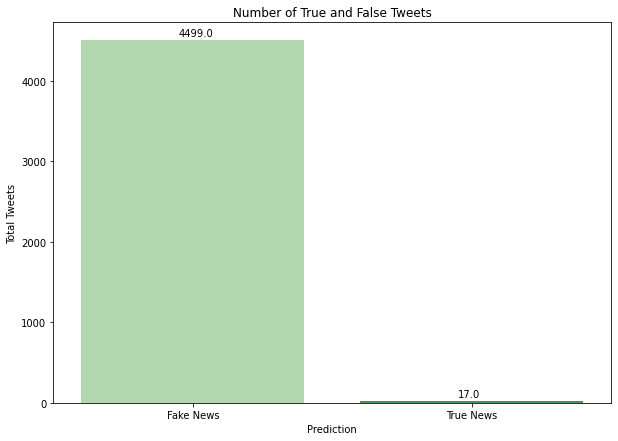

In [40]:
fig = plt.figure(figsize=(10,7))
ax = sns.countplot(data=tweets_df, x='prediction', palette='Greens')
for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.35, p.get_height()+50))
    ax.set(title="Number of True and False Tweets", xlabel='Prediction', ylabel='Total Tweets')

In [35]:
tweets_df['location']

0       Here There & Everywhere Canada
1                                 None
2                      London, England
3                         Planet Earth
4                                 None
                     ...              
4511                           New Zea
4512                              None
4513                              None
4514                            London
4515               the friends we made
Name: location, Length: 4516, dtype: object

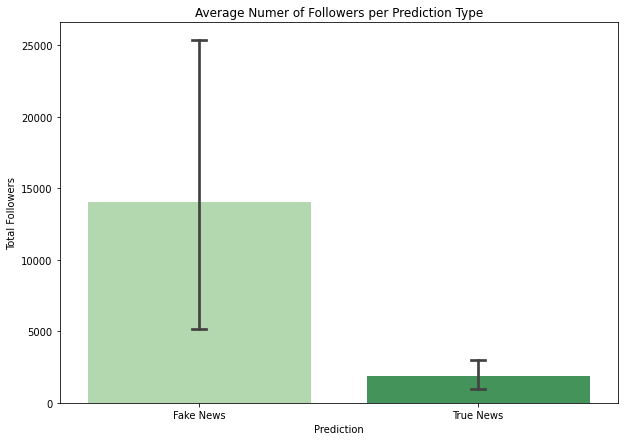

In [33]:
fig = plt.figure(figsize=(10,7))

ax = sns.barplot(data=tweets_df, x='prediction', y='followers_count', capsize=.05, palette='Greens')\
.set(title="Average Numer of Followers per Prediction Type", xlabel='Prediction', ylabel='Total Followers')

In [60]:
text_true = tweets_df[tweets_df['prediction']=='True News'][['Text']]
text_false = tweets_df[tweets_df['prediction']=='Fake News'][['Text']]

In [89]:
def print_wordCloud(df, title):
    comment_words = ''
    stopwords = set(STOPWORDS)

    # iterate through the csv file
    for val in df.Text:

        # typecaste each val to string
        val = str(val)

        # split the value
        tokens = val.split()

        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()

        comment_words += " ".join(tokens)+" "

    wordcloud = WordCloud(width = 1500, height = 1000,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(comment_words)

    # plot the WordCloud image                      
    plt.figure(figsize = (10, 10), facecolor = None)
    plt.imshow(wordcloud)
    plt.title(title, fontsize=25)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

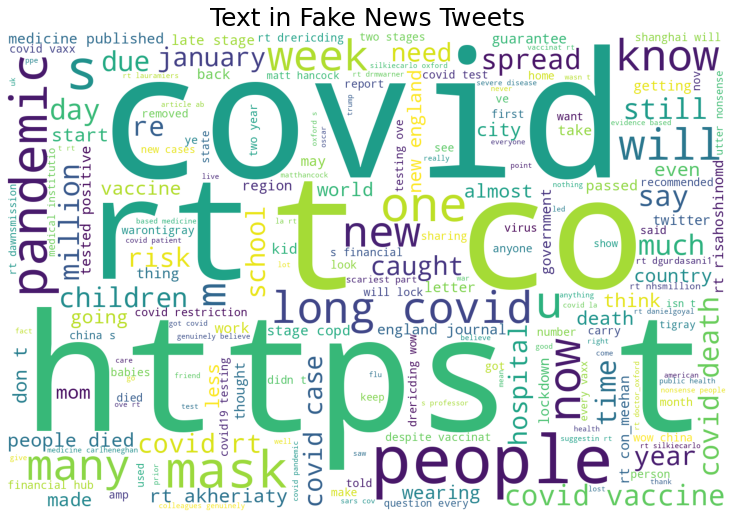

In [91]:
print_wordCloud(text_false, 'Text in Fake News Tweets')

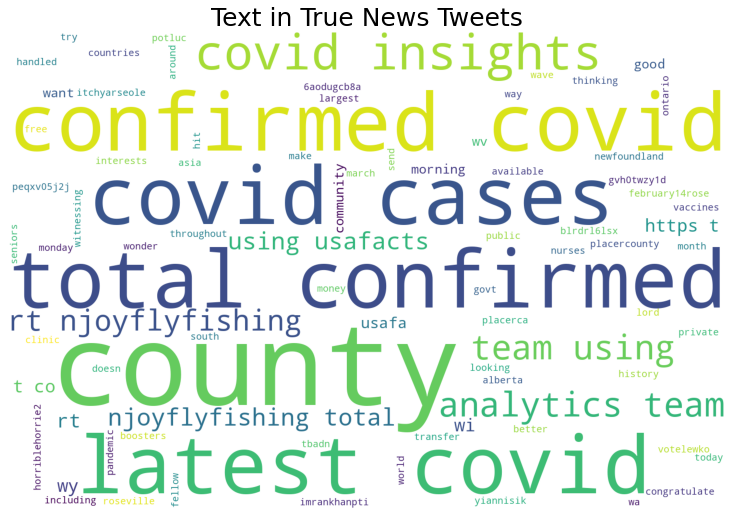

In [90]:
print_wordCloud(text_true, 'Text in True News Tweets')

<a id='4'></a>
# 5. Tear Down

Once we complete the the lab we should stop:

- This notebook
- HDFS
- MariaBD service
- Kafka service